<a href="https://colab.research.google.com/github/michelledo94/Airbnb-App-Sessions-EDA/blob/master/DSCI_521_Final_project_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data preparation

In [0]:
# libraries
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

import xgboost, textblob, string
import re
import nltk
from nltk.corpus import stopwords
import string

In [0]:
# load the dataset
data = open('corpus', encoding='utf8').read()
labels, texts = [], []
for i, line in enumerate(data.split("\n")):
    content = line.split()
    labels.append(content[0])
    texts.append(" ".join(content[1:]).lower())
    
# Extract train labels  
def return_label(string):
    label = re.findall('\d', string)
    if label is not None:
        return int(label[0])

    
# create a dataframe using texts and lables
df = pd.DataFrame()
df['text'] = texts
df['label'] = labels
df['label'] = df['label'].apply(lambda row: return_label(row))
df.head()

,text,label
0,stuning even for the non-gamer: this sound tra...,2
1,the best soundtrack ever to anything.: i'm rea...,2
2,amazing!: this soundtrack is my favorite music...,2
3,excellent soundtrack: i truly like this soundt...,2
4,"remember, pull your jaw off the floor after he...",2


## EDA

1    5097
2    4903
Name: label, dtype: int64


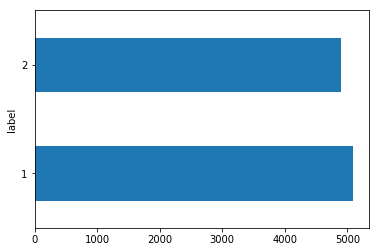

In [0]:
# label distribution (1=negative, 2=positive)
print(df['label'].value_counts())
df.groupby(['label']).size().plot(kind='barh')

In [0]:
# see wordcloud 
stop = stopwords.words('english') 
text = nltk.word_tokenize(" ".join(df['text'].tolist()))
cleanwords = [i for i in text if i not in stop and i.isalpha()]
print(cleanwords[:10])

['stuning', 'even', 'sound', 'track', 'beautiful', 'paints', 'senery', 'mind', 'well', 'would']


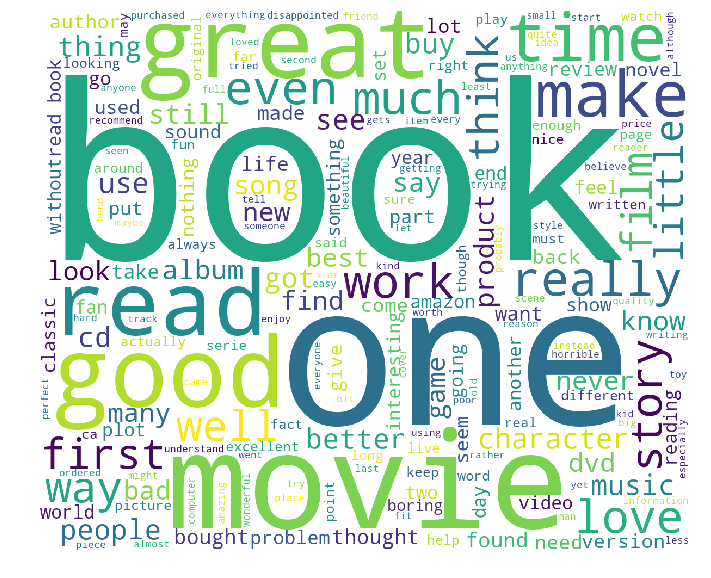

In [0]:
# prep the wordcloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords))

# plot
fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

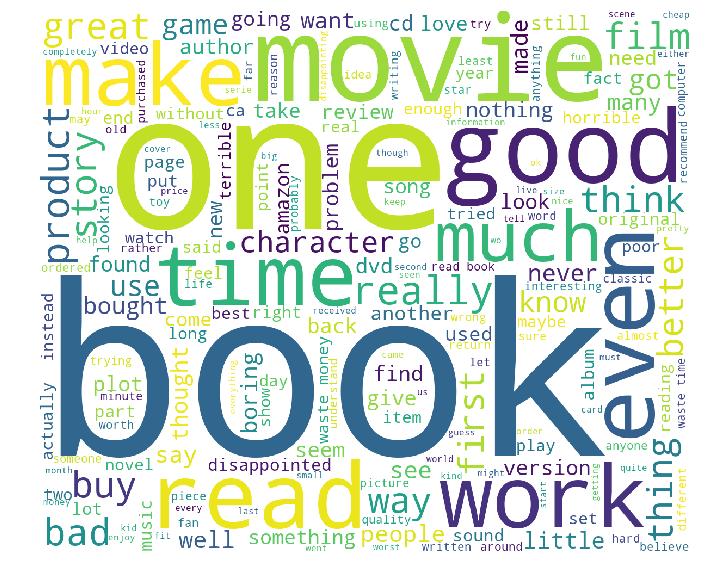

In [0]:
# wordcloud for negative reviews
df_neg = df[df['label']==1]
text_neg = nltk.word_tokenize(" ".join(df_neg['text'].tolist()))
cleanwords_neg = [i for i in text_neg if i not in stop and i.isalpha()]
wordcloud_neg = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords_neg))

fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

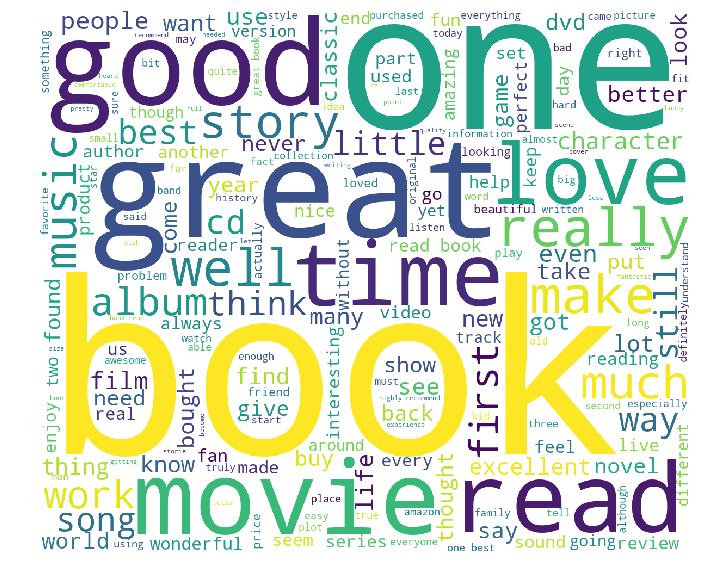

In [0]:
# wordcloud for positive reviews
df_pos = df[df['label']==2]
text_pos = nltk.word_tokenize(" ".join(df_pos['text'].tolist()))
cleanwords_pos = [i for i in text_pos if i not in stop and i.isalpha()]
wordcloud_pos = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=1200,
                          height=1000).generate(" ".join(cleanwords_pos))

fig_custom = plt.figure(figsize = (20, 10))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

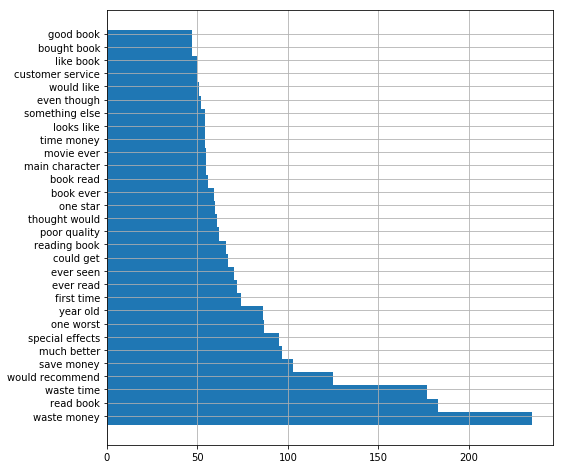

In [0]:
from collections import Counter
bigrams_neg = nltk.bigrams(cleanwords_neg)
counter_neg = Counter(bigrams_neg)
most_common_neg = sorted(counter_neg.most_common(30), key = lambda x: x[1], reverse=True)
labels = [" ".join(e[0]) for e in most_common_neg]
values = [e[1] for e in most_common_neg]
indexes = np.arange(len(labels))
width = 1
bigrams_fig = plt.figure(figsize = (8, 8))
plt.barh(indexes, values, width)

plt.yticks(indexes + width * 0.2, labels)
plt.grid()
plt.show()

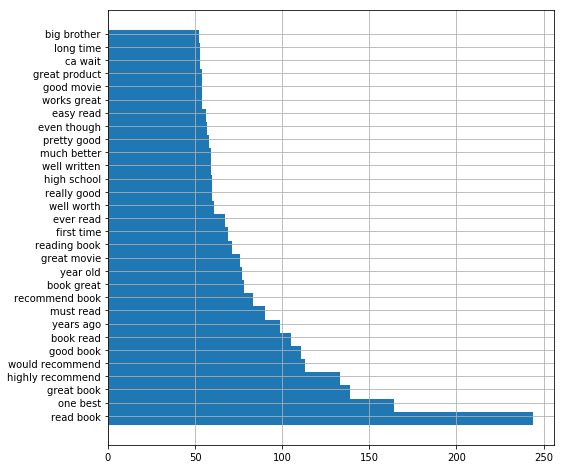

In [0]:
bigrams_pos = nltk.bigrams(cleanwords_pos)
counter_pos = Counter(bigrams_pos)
most_common_pos = sorted(counter_pos.most_common(30), key = lambda x: x[1], reverse=True)
labels = [" ".join(e[0]) for e in most_common_pos]
values = [e[1] for e in most_common_pos]
indexes = np.arange(len(labels))
width = 1
bigrams_fig = plt.figure(figsize = (8, 8))
plt.barh(indexes, values, width)

plt.yticks(indexes + width * 0.2, labels)
plt.grid()
plt.show()

## Feature engineering

In [0]:
# split into train and test sets  
x_train, x_test, y_train, y_test = model_selection.train_test_split(df['text'], df['label'],
                                                                    test_size=0.3, random_state=1, shuffle=True)

# split into train and validation sets    
x_valid, x_test, y_valid, y_test = model_selection.train_test_split(x_test, y_test,
                                                                    test_size=1/3, random_state=1, shuffle=True)

# label encoding into 0 and 1 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.fit_transform(y_valid)
y_test = encoder.fit_transform(y_test)

In [0]:
# CountVectorizer 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(df['text'])

xtrain_count =  count_vect.transform(x_train)
xvalid_count =  count_vect.transform(x_valid)
xtest_count = count_vect.transform(x_test)

In [0]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(df['text'])
xtrain_tfidf =  tfidf_vect.transform(x_train)
xvalid_tfidf =  tfidf_vect.transform(x_valid)
xtest_tfiddf = tfidf_vect.transform(x_test)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(df['text'])
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(x_valid)
xtest_tfidf_ngram = tfidf_vect_ngram.transform(x_test)

# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(df['text'])
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_valid) 
xtest_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(x_test)

In [0]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
for i, line in enumerate(open('./wiki-news-300d-1M.vec', encoding="utf8")):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

# create a tokenizer 
token = text.Tokenizer()
token.fit_on_texts(df['text'])
word_index = token.word_index

# convert text to sequence of tokens and pad them to ensure equal length vectors 
train_seq_x = sequence.pad_sequences(token.texts_to_sequences(train_x), maxlen=70)
valid_seq_x = sequence.pad_sequences(token.texts_to_sequences(valid_x), maxlen=70)

# create token-embedding mapping
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Model building

### k-Nearest Neighbors

The optimal number of neighbors is 45


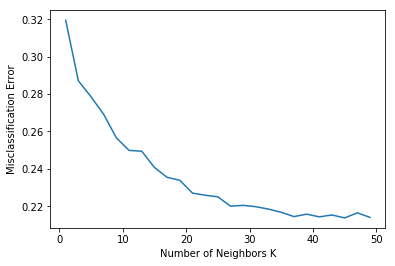

In [0]:
# kNN 
from sklearn.neighbors import KNeighborsClassifier

## creating odd list of K for KNN
neighbors = list(range(1, 50, 2)) # range 1:50 with step 2

## empty list that will hold cv scores
cv_scores = []

## perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain_tfidf, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
## computing misclassification error
mse = [1 - x for x in cv_scores]

## determining best k
optimal_k = neighbors[mse.index(min(mse))]
print("The optimal number of neighbors is {}".format(optimal_k))

## plot misclassification error vs k
plt.plot(neighbors, mse)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Misclassification Error")
plt.show()

In [0]:
knn = KNeighborsClassifier(n_neighbors=45)
knn.fit(xtrain_tfidf, y_train)
knn.score(xvalid_tfidf, y_valid)

0.787

### Support Vector Machines

In [0]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(xtrain_tfidf, y_train)
svm.score(xvalid_tfidf, y_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5055

### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain_tfidf.toarray(), y_train)
nb.score(xvalid_tfidf.toarray(), y_valid)

0.739

### Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(xtrain_tfidf, y_train)
rf.score(xvalid_tfidf, y_valid)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7305

### Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=0, multi_class='multinomial', solver='newton-cg')
logreg.fit(xtrain_tfidf, y_train)
logreg.score(xvalid_tfidf, y_valid)

0.861

In [0]:
from sklearn.metrics import roc_auc_score
logreg_valid_pred = logreg.predict(xvalid_tfidf)
auc = roc_auc_score(y_valid, logreg_valid_pred)
auc

0.8610491869516211

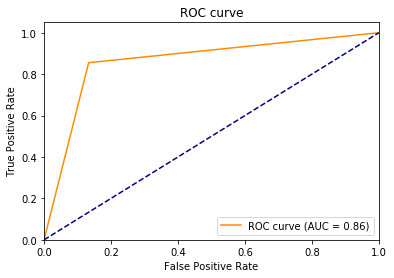

In [0]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(logreg_valid_pred, y_valid)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

### Boosting models

### Neural networks